In [1]:
using Base: @kwdef
using Parameters: @unpack
using Plots
using LinearAlgebra
using Distributions, Random

In [2]:
# 遅延時間をバラバラにしたい場合は、for loopが必須になるので注意

@kwdef mutable struct Delay_Connection{FT}
    N::UInt32 # ニューロンの数
    delay::Float32
    dt::Float32
    nt_delay::UInt32 = round(Int64,delay/dt)
    state::Matrix{FT} = zeros(N, nt_delay)
    out = zeros(N)
end 

#ifelse(条件式, 条件が一致した場合の処理, 条件が一致しなかった場合の処理)
function Delay_Connection_call!(variable::Delay_Connection, x, dt)
    @unpack N,delay,dt,nt_delay,state,out = variable
    #out = zeros(N, 1) # mutableに置くと毎回初期化されてしまうので注意
    out = state[:, end]
    state[:, 2:end] = state[:, 1:end-1]　# 配列をずらす(pythonだとこっちの方がnp.rollより早いらしい)
    state[:, 1] = x
    return out
end

Delay_Connection_call! (generic function with 1 method)

In [3]:
# kwdefを使うと初期値の設定をstruct内に入れられる(pythonのコンストラクタっぽく使える)

@kwdef struct CurrentLIFParameter_1{FT}
    tref::FT = 0 #不応期(ms)
    tc_m::FT = 1e-2 # 膜時定数(ms)
    vrest::FT = 0 # 静止膜電位(mV)
    vreset::FT = 0 # リセット電位(mV)
    vthr::FT = 1 # 閾膜電位(mV)
    vpeak::FT = 1 # ピーク電位(mV)
end

@kwdef mutable struct CurrentLIF_1{FT}
    param::CurrentLIFParameter_1 = CurrentLIFParameter_1{FT}()
    N::UInt32 # ニューロンの数
    v::Vector{FT} = fill(0, N) # 膜電位(mV)
    v_::Vector{FT} = fill(0, N) # 発火電位も記録する変数
    fire::Vector{Bool} = zeros(Bool, N) # 発火
    tlast::Vector{FT} = zeros(N) # 最後の発火時刻(ms)
    tcount::FT = 0 # 時間カウント
end 

In [4]:
# kwdefを使うと初期値の設定をstruct内に入れられる(pythonのコンストラクタっぽく使える)

@kwdef struct CurrentLIFParameter_2{FT}
    tref::FT = 0 #不応期(ms)
    tc_m::FT = 1e-1 # 膜時定数(ms)
    vrest::FT = 0 # 静止膜電位(mV)
    vreset::FT = 0 # リセット電位(mV)
    vthr::FT = 1 # 閾膜電位(mV)
    vpeak::FT = 1 # ピーク電位(mV)
end

@kwdef mutable struct CurrentLIF_2{FT}
    param::CurrentLIFParameter_2 = CurrentLIFParameter_2{FT}()
    N::UInt32 # ニューロンの数
    v::Vector{FT} = fill(0, N) # 膜電位(mV)
    v_::Vector{FT} = fill(0, N) # 発火電位も記録する変数
    fire::Vector{Bool} = zeros(Bool, N) # 発火
    tlast::Vector{FT} = zeros(N) # 最後の発火時刻(ms)
    tcount::FT = 0 # 時間カウント
end 

In [16]:
#ifelse(条件式, 条件が一致した場合の処理, 条件が一致しなかった場合の処理)
function cupdate_1!(variable::CurrentLIF_1, param::CurrentLIFParameter_1, I::Vector, dt)
    @unpack N, v, v_, fire, tlast, tcount = variable
    @unpack tref, tc_m, vrest, vreset, vthr, vpeak = param
    
    @inbounds @simd for i = 1:N
        #v[i] += dt * ((vrest - v[i] + I[i]) / tc_m) # 不応期がない場合
        v[i] += dt * ((dt*tcount) > (tlast[i] + tref)) * ((vrest - v[i] + I[i]) / tc_m)
    end
    @inbounds @simd for i = i:N
        fire[i] = v[i] >= vthr
        v_[i] = ifelse(fire[i], vpeak, v[i])
        v[i] = ifelse(fire[i], vreset, v[i])
        tlast[i] = ifelse(fire[i], dt*tcount, tlast[i]) # 発火時刻の更新
    end
end

cupdate_1! (generic function with 1 method)

In [17]:
#ifelse(条件式, 条件が一致した場合の処理, 条件が一致しなかった場合の処理)
function cupdate_2!(variable::CurrentLIF_2, param::CurrentLIFParameter_2, I::Vector, dt)
    @unpack N, v, v_, fire, tlast, tcount = variable
    @unpack tref, tc_m, vrest, vreset, vthr, vpeak = param
    
    @inbounds @simd for i = 1:N
        #v[i] += dt * ((vrest - v[i] + I[i]) / tc_m) # 不応期がない場合
        v[i] += dt * ((dt*tcount) > (tlast[i] + tref)) * ((vrest - v[i] + I[i]) / tc_m)
    end
    @inbounds @simd for i = i:N
        fire[i] = v[i] >= vthr
        v_[i] = ifelse(fire[i], vpeak, v[i])
        v[i] = ifelse(fire[i], vreset, v[i])
        tlast[i] = ifelse(fire[i], dt*tcount, tlast[i]) # 発火時刻の更新
    end
end

cupdate_2! (generic function with 1 method)

In [24]:
T = 0.1
dt = 1e-3
nt = UInt32(T/dt) # number of timesteps
N = 10 # ニューロンの数

# modelの定義
neuron1 = CurrentLIF_1{Float64}(N=N)
neuron2 = CurrentLIF_2{Float64}(N=N)
delay_connection = Delay_Connection{Float64}(N=N, delay=1e-2, dt=dt)

# 入力刺激
t = Array{Float32}(1:nt)*dt
I = repeat(2f0 * (t .> 0), 1, N)  # injection current

v_arr1 = zeros(Float64, nt, N)
v_arr2 = zeros(Float64, nt, N)

i=1;
@time for i in 1:nt
    cupdate_1!(neuron1, neuron1.param, I[i,:], dt)
    neuron1.tcount += 1
    v_arr1[i, :] = neuron1.v_
    
    ret = Delay_Connection_call!(delay_connection, neuron1.fire, dt)
    #println(ret)
    #cupdate!(neuron2, neuron2.param, Float32.(reshape(0.02/dt*delay_connection.out, 10, )), dt)
    cupdate_2!(neuron2, neuron2.param, 0.02/dt*ret, dt)
    #cupdate_2!(neuron2, neuron2.param, 1/dt*ret, dt)
    neuron2.tcount += 1
    v_arr2[i, :] = neuron2.v_ 
end

  0.000945 seconds (17.90 k allocations: 404.719 KiB)


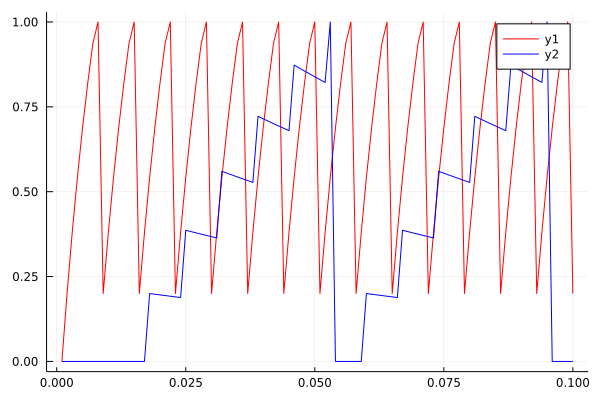

In [25]:
t = Array{Float32}(1:nt)*dt
plot(t, v_arr1[:, 1], color="red")
plot!(t, v_arr2[:, 1], color="blue")
#plot(p1, p2, 
#    xlabel = ["" "Times (ms)"], 
#    ylabel= ["V (mV)" "V (mV)"],
#    layout = grid(2, 1, heights=[0.5, 0.5]), legend=false, size=(600,300))

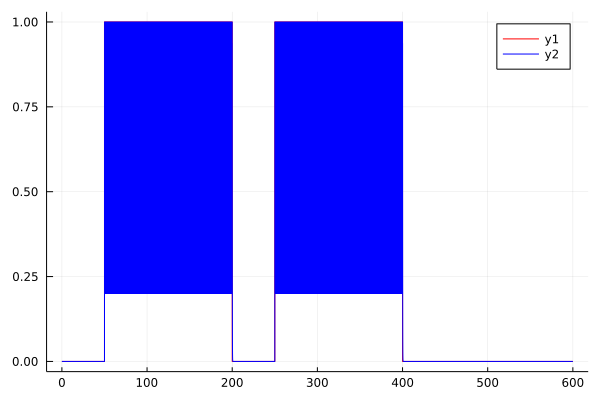

In [23]:
t = Array{Float32}(1:nt)*dt
plot(t, v_arr1[:, 1], color="red")
plot!(t, v_arr2[:, 1], color="blue")
#plot(p1, p2, 
#    xlabel = ["" "Times (ms)"], 
#    ylabel= ["V (mV)" "V (mV)"],
#    layout = grid(2, 1, heights=[0.5, 0.5]), legend=false, size=(600,300))